In [1]:
%pip install --quiet jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [4]:
%sql duckdb:///./387575.duckdb

Connecting to 'duckdb:///./387575.duckdb'

In [5]:
%sqlcmd tables

Name
Gateway
Site
Node
Message
Trace
Radio
Power_Consumption
Downlink_Event_Error_Message
Join_Message
Content_Message


In [6]:
%sql hej =<< select message from Trace WHERE message LIKE 'TIMINGS>%'

,message
0,"TIMINGS> Loop: 0, Sync: 403 ms, Load: 0 ms, se..."
1,"TIMINGS> Loop: 0, Sync: 403 ms, Load: 0 ms, se..."


In [7]:
hej["message"][0]

'TIMINGS> Loop: 0, Sync: 403 ms, Load: 0 ms, sensor init: 10 ms, env init: 0 ms, net init: 12267 ms, Listen: 2 ms, Collect: 19 ms, Exec: 0 ms, Send: 7252 ms, save config: 2489 ms, Sleep: 7 s\n'

In [8]:
%sql nodes =<< select distinct * from Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board
0,70B3D57ED005E88A,0000000000000000,793642F96160FCDBE923812F1607F9E3,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1


In [9]:

timestamps= %sql select timestamp from Power_Consumption 
#timestamps = timestamps["timestamp"].map(lambda x: x.isoformat())
%sql SUMMARIZE Power_Consumption

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,power_consumption_id,INTEGER,1,281209,283642,140605.0,81178.19026171218,70447,140357,211219,281209,0.0%
1,node_id,VARCHAR,70B3D57ED005E88A,70B3D57ED005E88A,1,None,None,None,None,None,281209,0.0%
2,timestamp,TIMESTAMP,2023-12-11 13:07:22.657116,2023-12-11 13:12:28.31462,275303,None,None,None,None,None,281209,0.0%
3,current,FLOAT,-4.9e-05,0.245507,1136,0.056882432149741737,0.006154287672005472,0.055704002608670235,0.05619928586064401,0.05671346062247097,281209,0.0%
4,voltage,FLOAT,1.61625,4.9275,357,4.854690825102917,0.1199392082136566,4.858441355550067,4.860000133514404,4.861249923706055,281209,0.0%
5,power,FLOAT,0.0,1.195303,372,0.27646114422577756,0.029879525363132545,0.27073045888070607,0.2731041542595577,0.2759025822604653,281209,0.0%


In [10]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from Power_Consumption group by node_id

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005E88A,281209,2023-12-11 13:07:22.657116,2023-12-11 13:12:28.314620


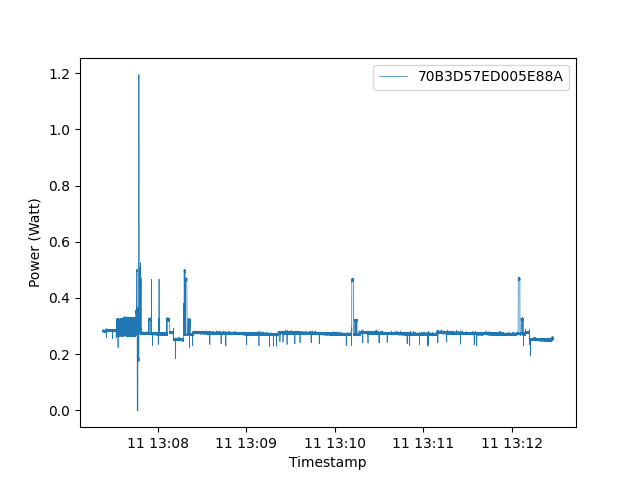

In [11]:
deveui = "70B3D57ED005EA56"

power_consumption= %sql select timestamp,power,current,voltage,node_id from Power_Consumption
power_consumption = power_consumption.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power_consumption.groupby("node_id")
plt.figure()
for node_id, group in groups:
    plt.plot(group.index, group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.legend()
plt.show()

## finding sync signals

In [12]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

#diff of each group
power_consumption['power_diff'] = groups["power"].diff()
power_diff = power_consumption['power_diff']

# single node
power_single = power_consumption[(power_consumption["node_id"] =="70B3D57ED005E88A")]


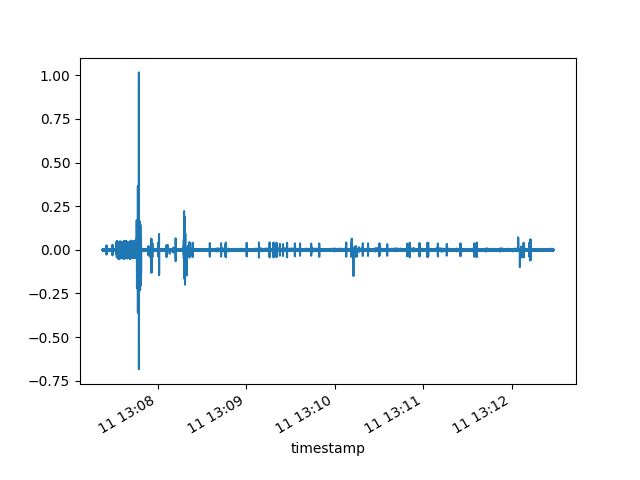

In [13]:
plt.figure()
power_diff.plot()
plt.show()

In [14]:
rising_edge = power_consumption[power_diff > 0.02].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_diff < -0.02].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2023-12-11 13:07:25.350438,0.258840,0.058849,4.86125,70B3D57ED005E88A,-0.027471,falling
2023-12-11 13:07:25.351536,0.284480,0.058508,4.85625,70B3D57ED005E88A,0.025640,rising
2023-12-11 13:07:29.426351,0.255177,0.058385,4.86000,70B3D57ED005E88A,-0.031745,falling
2023-12-11 13:07:29.427419,0.284480,0.058483,4.86250,70B3D57ED005E88A,0.029303,rising
2023-12-11 13:07:31.952334,0.260061,0.058898,4.86000,70B3D57ED005E88A,-0.025029,falling


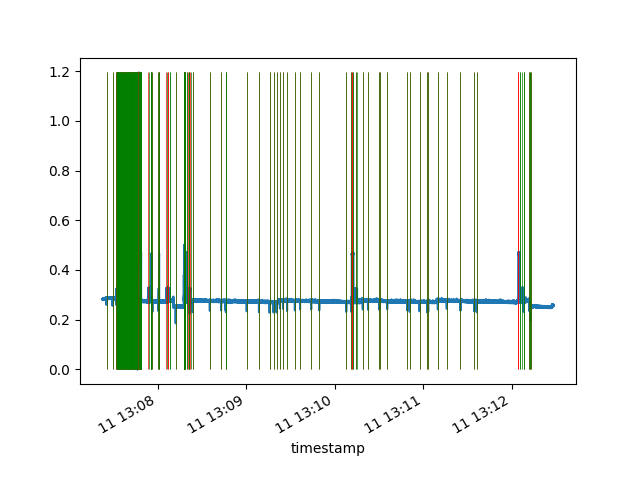

In [15]:
plt.figure()
power_single['power'].plot(label="power")
plt.vlines(edges[edges['direction'] == 'rising'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.vlines(edges[edges['direction'] == 'falling'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5)

plt.show()

In [16]:
# only keep edges where direction differ
edges['next_direction'] = edges['direction'].shift(-1)
edges['next_timestamp'] = edges.index.to_series().shift(-1)
edges = edges[(edges['direction'] != edges['next_direction']) & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=210))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=190)))]
edges.head()


,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp
timestamp,,,,,,,,
2023-12-11 13:07:45.811628,0.498755,0.102706,4.85375,70B3D57ED005E88A,0.169100,rising,falling,2023-12-11 13:07:46.011617
2023-12-11 13:07:47.893082,0.505470,0.104146,4.85500,70B3D57ED005E88A,0.164216,rising,falling,2023-12-11 13:07:48.093071
2023-12-11 13:08:17.922744,0.497534,0.102388,4.86000,70B3D57ED005E88A,0.222211,rising,falling,2023-12-11 13:08:18.122733
2023-12-11 13:08:18.356440,0.494482,0.101827,4.85500,70B3D57ED005E88A,0.189857,rising,falling,2023-12-11 13:08:18.556429


In [17]:
## add counter to sync signals and add sync signal start and end times
edges.loc[:,'sync_num'] = range(len(edges)) 
edges.loc[:, 'sync_start'] = edges.index - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num,sync_start,sync_end
timestamp,,,,,,,,,,,
2023-12-11 13:07:45.811628,0.498755,0.102706,4.85375,70B3D57ED005E88A,0.169100,rising,falling,2023-12-11 13:07:46.011617,0,2023-12-11 13:07:45.711628,2023-12-11 13:07:46.111617
2023-12-11 13:07:47.893082,0.505470,0.104146,4.85500,70B3D57ED005E88A,0.164216,rising,falling,2023-12-11 13:07:48.093071,1,2023-12-11 13:07:47.793082,2023-12-11 13:07:48.193071
2023-12-11 13:08:17.922744,0.497534,0.102388,4.86000,70B3D57ED005E88A,0.222211,rising,falling,2023-12-11 13:08:18.122733,2,2023-12-11 13:08:17.822744,2023-12-11 13:08:18.222733
2023-12-11 13:08:18.356440,0.494482,0.101827,4.85500,70B3D57ED005E88A,0.189857,rising,falling,2023-12-11 13:08:18.556429,3,2023-12-11 13:08:18.256440,2023-12-11 13:08:18.656429


In [23]:
#based on sync_num add loop timings
edges.loc[:,'loop_num'] = ((edges['sync_num']))
edges.head()

,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num,sync_start,sync_end,loop_num
timestamp,,,,,,,,,,,,
2023-12-11 13:07:45.811628,0.498755,0.102706,4.85375,70B3D57ED005E88A,0.169100,rising,falling,2023-12-11 13:07:46.011617,0,2023-12-11 13:07:45.711628,2023-12-11 13:07:46.111617,0
2023-12-11 13:07:47.893082,0.505470,0.104146,4.85500,70B3D57ED005E88A,0.164216,rising,falling,2023-12-11 13:07:48.093071,1,2023-12-11 13:07:47.793082,2023-12-11 13:07:48.193071,1
2023-12-11 13:08:17.922744,0.497534,0.102388,4.86000,70B3D57ED005E88A,0.222211,rising,falling,2023-12-11 13:08:18.122733,2,2023-12-11 13:08:17.822744,2023-12-11 13:08:18.222733,2
2023-12-11 13:08:18.356440,0.494482,0.101827,4.85500,70B3D57ED005E88A,0.189857,rising,falling,2023-12-11 13:08:18.556429,3,2023-12-11 13:08:18.256440,2023-12-11 13:08:18.656429,3


In [24]:
# create table of loops by taking every second row and excluding the first edge (which is just program start)
# the index is when (we think) the loop starts. that is 100 ms after next_timestamp.
# also remove all irrelevant columns

loops = edges[['node_id', 'next_timestamp', 'loop_num']]
## change index to be loop start time. i.e. 100 ms after next timestamp
loops['loop_start'] = loops.next_timestamp + pd.Timedelta(milliseconds=100)
loops.set_index('loop_start', inplace=True)
loops.drop('next_timestamp', axis=1, inplace=True)
loops.head()

/tmp/ipykernel_1014050/3779518967.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loops['loop_start'] = loops.next_timestamp + pd.Timedelta(milliseconds=100)
/tmp/ipykernel_1014050/3779518967.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loops.drop('next_timestamp', axis=1, inplace=True)


,node_id,loop_num
loop_start,,
2023-12-11 13:07:46.111617,70B3D57ED005E88A,0
2023-12-11 13:07:48.193071,70B3D57ED005E88A,1
2023-12-11 13:08:18.222733,70B3D57ED005E88A,2
2023-12-11 13:08:18.656429,70B3D57ED005E88A,3


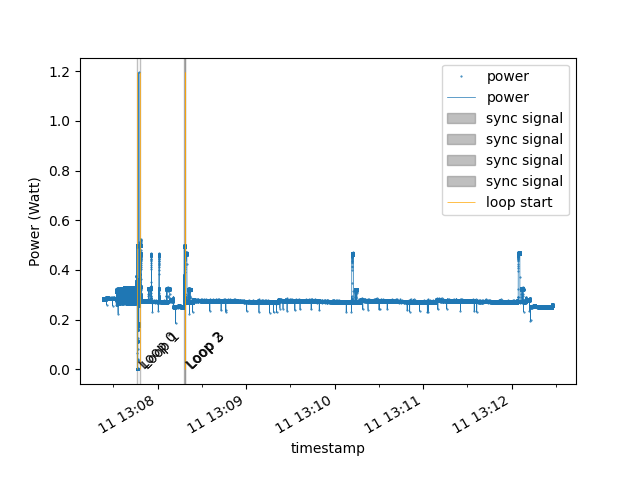

In [26]:
plt.figure()
power_single['power'].plot(style='.',markersize=1, label="power")
power_single['power'].plot(linewidth=0.5, color='tab:blue', label="power")
plt.ylabel("Power (Watt)")

## add sync signal indication
for row in edges.itertuples():
    plt.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5, label="sync signal")
# plt.vlines(edges.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5, label="rising edge")
# plt.vlines(edges['next_timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5, label="falling edge")
plt.vlines(loops.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="orange", linewidth=0.5, label="loop start")
for row in loops.itertuples():

    #odd row num indicates start sync
    plt.text(row.Index, 0, f"Loop {row.loop_num}", rotation=45)
plt.legend()
plt.gca().xaxis.set_major_locator(dates.AutoDateLocator())
plt.gca().xaxis.set_minor_locator(dates.AutoDateLocator(minticks=10, maxticks=20))
plt.show()

In [ ]:
# 'TIMINGS> Loop: 0, Sync: 403 ms, Load: 0 ms, sensor init: 10 ms, env init: 0 ms, net init: 12267 ms, Listen: 2 ms, Collect: 19 ms, Exec: 0 ms, Send: 7252 ms, save config: 2489 ms, Sleep: 7 s\n'
%%sql
timings << 
select 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: ([0-9]+)',1) as loop_num_ms,
    regexp_extract(message, '.*Sync: ([0-9]+)',1) as sync_time_ms,
    regexp_extract(message, '.*Load: ([0-9]+)',1) as load_time_ms,
    regexp_extract(message, '.*sensor init: ([0-9]+)',1) as sensor_init_time_ms,
    regexp_extract(message, '.*env init: ([0-9]+)',1) as env_init_time_ms,
    regexp_extract(message, '.*net init: ([0-9]+)',1) as net_init_time_ms,
    regexp_extract(message, '.*Listen: ([0-9]+)',1) as listen_time_ms,
    regexp_extract(message, '.*Collect: ([0-9]+)',1) as collect_time_ms,
    regexp_extract(message, '.*Exec: ([0-9]+)',1) as exec_time_ms,
    regexp_extract(message, '.*Send: ([0-9]+)',1) as send_time_ms,
    regexp_extract(message, '.*save config: ([0-9]+)',1) as save_config_time_ms,
    regexp_extract(message, '.*Sleep: ([0-9]+)',1) as sleep_time_s
     from Trace WHERE message LIKE 'TIMINGS>%'

In [ ]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time', 'listen_time', 'collect_time', 'exec_time', 'send_time', 'sleep_time', 'total_time']] = timings[['loop_num', 'sync_time', 'listen_time', 'collect_time', 'exec_time', 'send_time', 'sleep_time', 'total_time']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('loop_start')
loops.head()

,node_id,loop_num,timestamp,sync_time,listen_time,collect_time,exec_time,send_time,sleep_time,total_time
loop_start,,,,,,,,,,
2023-12-07 15:56:15.059748,70B3D57ED005E88A,0,2023-12-07 16:56:15.072490,403,0,18,0,5125,0,NaN


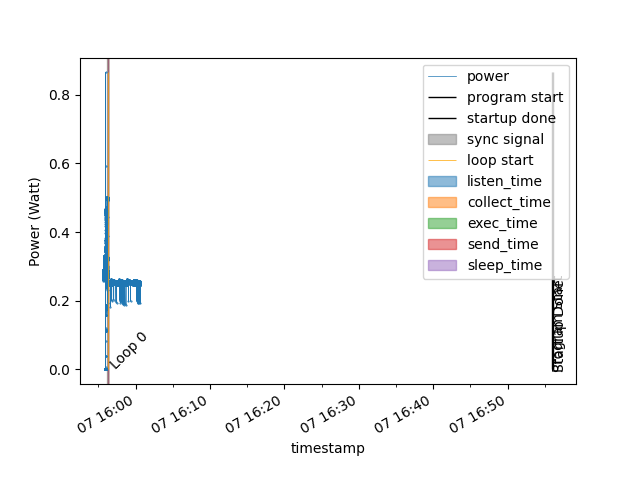

In [ ]:
for row in loops.itertuples():
    start_time = row.Index
    listen_time_start = start_time
    listen_time_end = start_time + pd.Timedelta(milliseconds=row.listen_time)
    collect_time_start = listen_time_end
    collect_time_end = collect_time_start + pd.Timedelta(milliseconds=row.collect_time)
    exec_time_start = collect_time_end
    exec_time_end = exec_time_start + pd.Timedelta(milliseconds=row.exec_time)
    send_time_start = exec_time_end
    send_time_end = send_time_start + pd.Timedelta(milliseconds=row.send_time)
    sleep_time_start = send_time_end
    sleep_time_end = sleep_time_start + pd.Timedelta(milliseconds=row.sleep_time)
    plt.axvspan(listen_time_start, listen_time_end, color='tab:blue', alpha=0.5, label="listen_time")
    plt.axvspan(collect_time_start, collect_time_end, color='tab:orange', alpha=0.5, label="collect_time")
    plt.axvspan(exec_time_start, exec_time_end, color='tab:green', alpha=0.5, label="exec_time")
    plt.axvspan(send_time_start, send_time_end, color='tab:red', alpha=0.5, label="send_time")
    plt.axvspan(sleep_time_start, sleep_time_end, color='tab:purple', alpha=0.5, label="sleep_time")
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [ ]:
# get all relevant frame-events
%sql send_frame_start << select * from Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from Trace WHERE message LIKE '%received something%'

In [ ]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

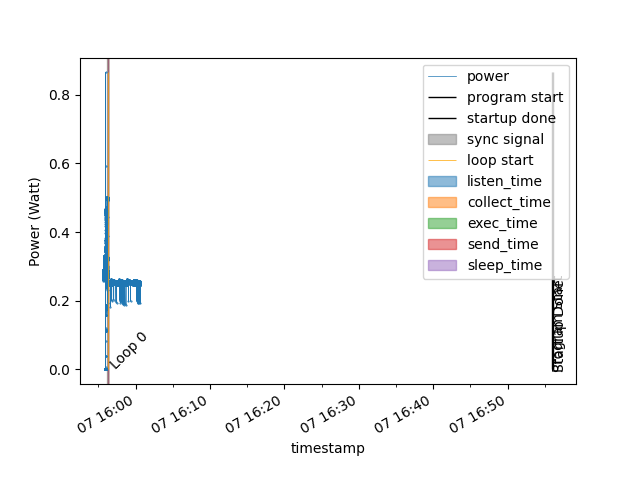

In [ ]:
# add send and receive columns to plot

for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
    start_time = send_start_row.timestamp
    end_time = send_end_row.timestamp
    plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
    start_time = receive_frame_start.timestamp
    end_time = receive_frame_end.timestamp
    plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [ ]:
%%sql
res <<
select timestamp, AVG(power) OVER blink AS 'avg_power_blink'
FROM Power_Consumption
WINDOW blink AS (
    PARTITION BY node_id
    ORDER BY timestamp ASC
    RANGE BETWEEN INTERVAL 100 MILLISECOND PRECEDING AND INTERVAL 100 MILLISECOND FOLLOWING
    )

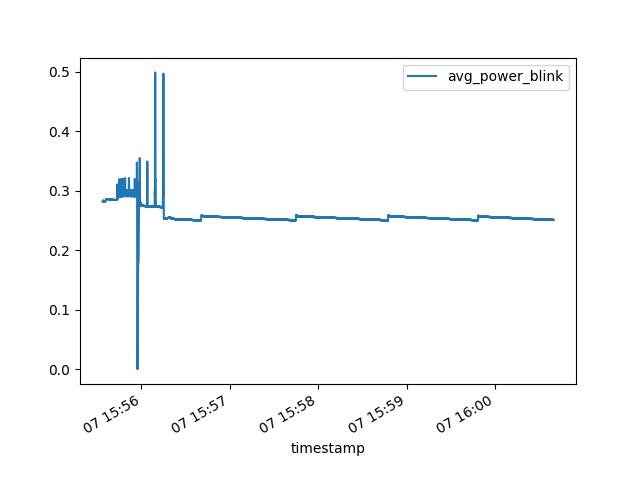

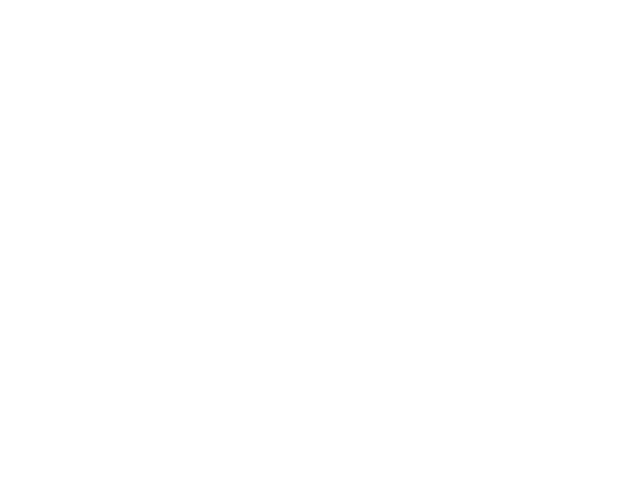

In [ ]:
plt.figure()
res.plot(x='timestamp')
plt.show()

In [ ]:
# Clean edge detection
#remove values where difference is not greater or less than 5 seconds
diff = filtered_power_diff.index.to_series().diff(-1).abs()
plt.figure()
plt.ylabel("Power")
# single node

power_single["power"].plot()

plt.vlines(filtered_power_diff.index[(diff < pd.Timedelta(seconds=5.5))  & (diff > pd.Timedelta(seconds=4.5))], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.show()

NameError: name 'filtered_power_diff' is not defined

In [ ]:
%sql select count(*) from Trace

,count_star()
0,607


In [ ]:
#traces from single node
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A'

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-11-02 10:44:44.111270,�'/!8@!8UP�����Join procedure succeededcreatin...
1,2,70B3D57ED005E88A,2023-11-02 10:44:44.111979,Sending: <3\n
2,3,70B3D57ED005E88A,2023-11-02 10:44:49.218133,"Startup done. Timings: sensor init: 14 ms, env..."
3,4,70B3D57ED005E88A,2023-11-02 10:44:49.220100,Main loop iteration\n
4,5,70B3D57ED005E88A,2023-11-02 10:44:49.222096,Running single blink...\n
...,...,...,...,...
602,603,70B3D57ED005E88A,2023-11-02 10:49:19.918121,collecting data from sensor lps22hb\n
603,604,70B3D57ED005E88A,2023-11-02 10:49:19.924045,Read value from Sensor lps22hb. Saving in env...
604,605,70B3D57ED005E88A,2023-11-02 10:49:19.926032,Execute Queries...\n
605,606,70B3D57ED005E88A,2023-11-02 10:49:19.928118,Sending Responses if any...\n


In [ ]:
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A' AND message LIKE '>TIMINGS%'

,trace_id,node_id,timestamp,message


In [ ]:
def get_timings_from_trace(trace: str):
    

SyntaxError: incomplete input (2969963752.py, line 2)

In [ ]:
# lower=widgets.SelectionSlider(options=timestamps, value=timestamps.min())
# upper=widgets.SelectionSlider(options=timestamps, value=timestamps.max())
# %sql --save hej --interact deveuis --interact lower --interact upper SELECT * from Power_Consumption where node_id LIKE '{{deveuis}}' AND timestamp BETWEEN '{{lower}}' AND '{{upper}}'